In [60]:
import torch
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float64) / 256.
    depth[depth_png == 0] = -1.
    return depth


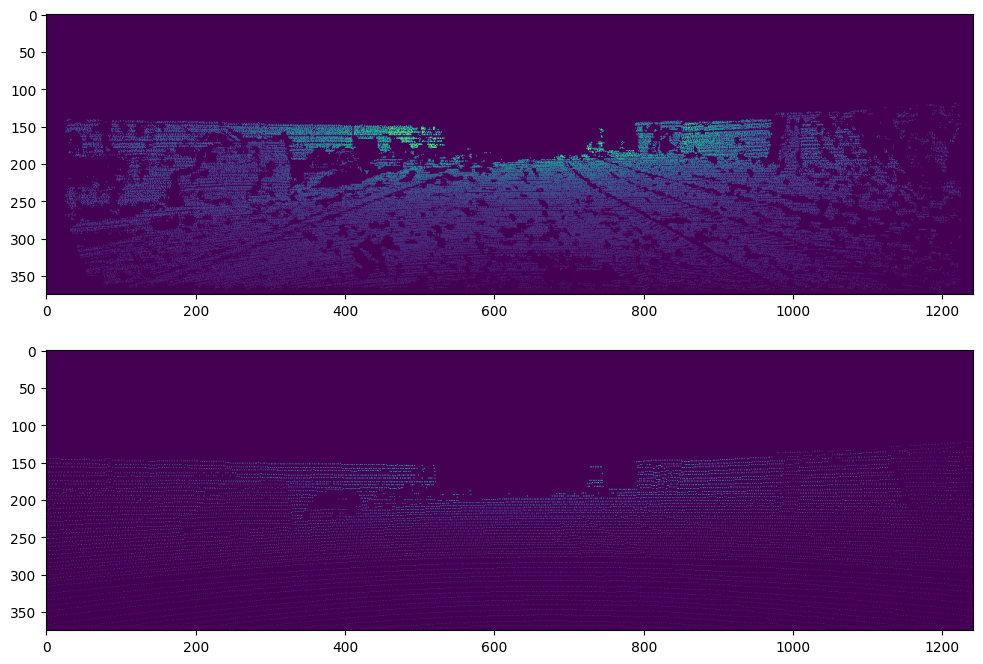

In [61]:

groundtruth_path = "E:/KITTI/data_depth_annotated/train/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02"
raw_path = "E:/KITTI/data_depth_velodyne/train/2011_09_26_drive_0001_sync/proj_depth/velodyne_raw/image_02"
imgs_filename = os.listdir(groundtruth_path)
depth_img = depth_read(os.path.join(groundtruth_path,imgs_filename[0]))
depth_raw = depth_read(os.path.join(raw_path,imgs_filename[0]))
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.imshow(depth_img)
plt.subplot(212)
plt.imshow(depth_raw)


In [62]:
conv = torch.nn.Conv2d(1,1,3,1,1)
conv.weight

Parameter containing:
tensor([[[[-0.3184,  0.2716, -0.2408],
          [-0.0459,  0.3051,  0.3191],
          [ 0.0825, -0.0881,  0.1951]]]], requires_grad=True)

In [63]:
torch.nn.init.constant_(conv.weight,1)
pool = torch.nn.AvgPool2d(3,1,1)
input = torch.arange(1,26,1).reshape((1,1,5,5)).double()
input[input<3] = 3
input,pool(input),conv(input.to(torch.float32)),1/input

(tensor([[[[ 3.,  3.,  3.,  4.,  5.],
           [ 6.,  7.,  8.,  9., 10.],
           [11., 12., 13., 14., 15.],
           [16., 17., 18., 19., 20.],
           [21., 22., 23., 24., 25.]]]], dtype=torch.float64),
 tensor([[[[ 2.1111,  3.3333,  3.7778,  4.3333,  3.1111],
           [ 4.6667,  7.3333,  8.1111,  9.0000,  6.3333],
           [ 7.6667, 12.0000, 13.0000, 14.0000,  9.6667],
           [11.0000, 17.0000, 18.0000, 19.0000, 13.0000],
           [ 8.4444, 13.0000, 13.6667, 14.3333,  9.7778]]]],
        dtype=torch.float64),
 tensor([[[[ 19.2677,  30.2677,  34.2677,  39.2677,  28.2677],
           [ 42.2677,  66.2677,  73.2677,  81.2677,  57.2677],
           [ 69.2677, 108.2677, 117.2677, 126.2677,  87.2677],
           [ 99.2677, 153.2677, 162.2677, 171.2677, 117.2677],
           [ 76.2677, 117.2677, 123.2677, 129.2677,  88.2677]]]],
        grad_fn=<ConvolutionBackward0>),
 tensor([[[[0.3333, 0.3333, 0.3333, 0.2500, 0.2000],
           [0.1667, 0.1429, 0.1250, 0.1111, 0.1000

In [64]:
import torch.nn as nn
class SparseConvolutionLayer(torch.nn.Module):
    def __init__(self,in_channel=1,out_channel=1,kernel_size = 3,padding = 1):
        super().__init__()
        self.kernel_size = kernel_size
        self.weight = nn.Conv2d(in_channel,out_channel,kernel_size,padding=padding,bias=False)
        torch.nn.init.constant_(self.weight.weight,1)
        self.mean_weight = nn.AvgPool2d(kernel_size,1,padding=padding)
        self.eps = 0.001
        self.bias = torch.empty(1,requires_grad=True)
        self.mask_maxpool = nn.MaxPool2d(kernel_size,1,padding=padding)
        torch.nn.init.zeros_(self.bias)
    def forward(self,feature,mask):
        y = feature*mask
        y = self.weight(y)
        y_mask = self.mean_weight(mask)*self.kernel_size**2
        y_mask[y_mask<self.eps] = self.eps
        y_mask = 1/y_mask
        # normilize
        output_feature = y*y_mask + self.bias
        # output_feature = y + self.bias
        output_mask = self.mask_maxpool(mask)
        return (output_feature,output_mask)

In [65]:
layer = SparseConvolutionLayer(1,16,kernel_size=11,padding=5).double()

In [73]:
a = torch.ones((1,1,100,100)).double()
b = torch.ones((1,1,100,100)).double()
a,b = layer(a,b)
a.shape,b.shape

(torch.Size([1, 16, 100, 100]), torch.Size([1, 1, 100, 100]))

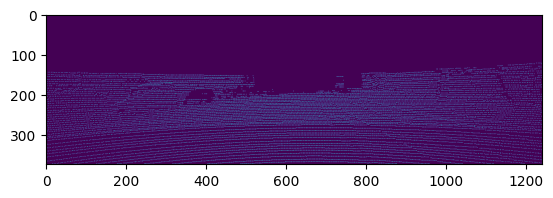

In [66]:
feature = torch.asarray(depth_raw[None,None])
mask = torch.ones_like(feature)
mask[feature<0] = 0
plt.imshow(mask[0,0])

In [67]:
feature_output,mask_output = layer(feature,mask)

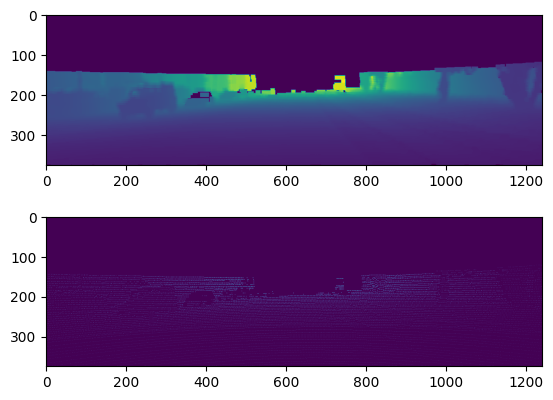

In [56]:
plt.subplot(211)
plt.imshow(feature_output.detach().numpy()[0,0])
plt.subplot(212)
plt.imshow(feature.detach().numpy()[0,0])

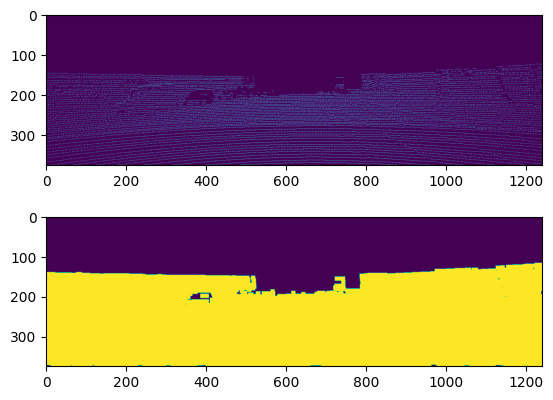

In [57]:
plt.subplot(211)
plt.imshow(mask.detach().numpy()[0,0])
plt.subplot(212)
plt.imshow(mask_output.detach().numpy()[0,0])

tensor(0.4401, dtype=torch.float64)

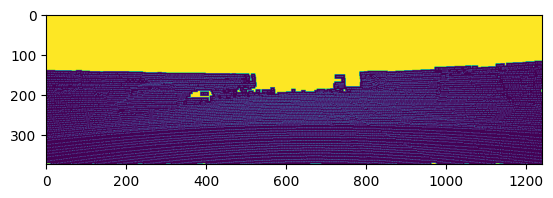

In [58]:
eps = 0.2
a = mask<=mask_output+eps
b = mask>=mask_output-eps
x = a*b
plt.imshow(x.detach().numpy()[0,0])
x.double().mean()
# mask.shape,mask_output.shape

zeros in feature:
input:446596.0,output:185809.0


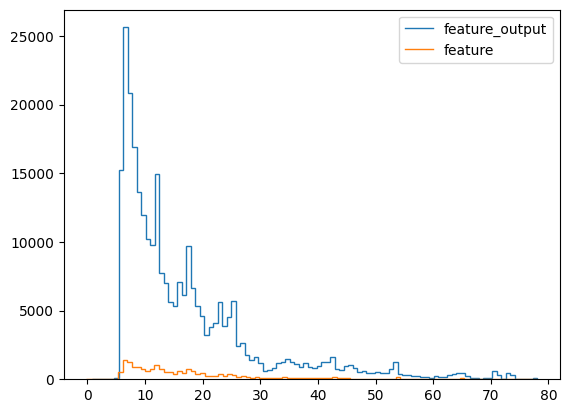

In [59]:
hist1,bins1 = torch.histogram(feature_output)
plt.stairs(hist1.detach().numpy()[1:],bins1.detach().numpy()[1:])
hist2,bins2 = torch.histogram(feature)
plt.stairs(hist2.detach().numpy()[1:],bins2.detach().numpy()[1:])
plt.legend(["feature_output","feature"])
print(f"zeros in feature:\ninput:{hist2[0]},output:{hist1[0]}")

zeros in mask:
input:446596.0,output:179647.0


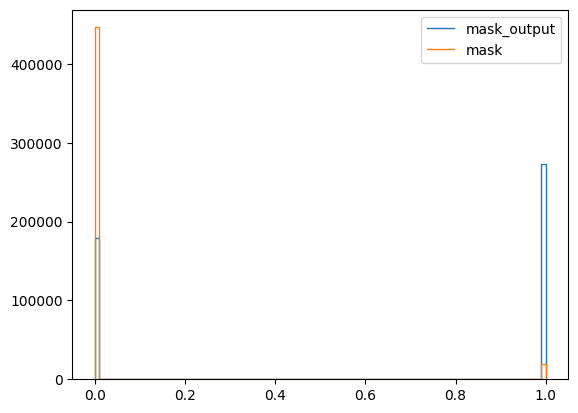

In [52]:
hist1,bins1 = torch.histogram(mask_output)
plt.stairs(hist1.detach().numpy(),bins1.detach().numpy())
hist2,bins2 = torch.histogram(mask)
plt.stairs(hist2.detach().numpy(),bins2.detach().numpy())
plt.legend(["mask_output","mask"])
print(f"zeros in mask:\ninput:{hist2[0]},output:{hist1[0]}")

In [75]:
a = torch.ones((1,3,100,100))
b = torch.ones((1,1,100,100))
bias = torch.ones((1,3,1,1))
out = a*b+bias
out.shape

torch.Size([1, 3, 100, 100])

In [78]:
a = np.ones((1,2,1,3))
np.squeeze(a)

array([[1., 1., 1.],
       [1., 1., 1.]])